In [1]:
import math
import torch

device = torch.device("cuda")

max_seq_len = 64


In [2]:
class Embedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        out = self.embed(x)
        return out

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim
        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (2 * i / self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * (i + 1) / self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)       # pre-calculate and freeze

    def forward(self, x):
        seq_len = x.size(1)
        return x * math.sqrt(self.embed_dim) + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        # return x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)

In [4]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.single_head_dim = self.embed_dim // self.num_heads   # 512 / 8 = 64, every head takes its part of the input
        self.query_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)  # a big matrix for the whole input
        self.key_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)    # we will split the heads later on
        self.value_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.mixer = torch.nn.Linear(self.embed_dim, self.embed_dim)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V shapes are (batch x length x single_head_dim) == (32 x 10 x 64)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.single_head_dim)
        # scores shape is (batch x length x length) == (32 x 10 x 10)
        if mask is not None:
            scores = scores.masked_fill(mask == False, -1e9)    # put large negative numbers to positions where mask == False
        probs = torch.softmax(scores, dim=-1)                   # transform scores to probabilities (B x L x L)
                                                                # for each sample in the batch tell how ith token is important to jth token
        return torch.matmul(probs, V)                           # re-weigh values according to the probabilities

    def split_heads(self, x):
        batch_size, seq_length, embed_dim = x.size()            # B x L x D
        assert self.embed_dim == embed_dim
        return x.view(                                          # B x L x H x d
            batch_size,
            seq_length,
            self.num_heads,
            self.single_head_dim,
        ).transpose(1, 2)                                       # B x H x L x d
        
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, single_head_dim = x.size()
        assert self.num_heads == num_heads
        assert self.single_head_dim == single_head_dim
        # B x H x L x d   => 
        # B x L x H x d   =>
        # B x L x D
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.query_matrix(Q))
        K = self.split_heads(self.key_matrix(K))
        V = self.split_heads(self.value_matrix(V))        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.mixer(self.combine_heads(attn_output))

In [5]:
class FeedForward(torch.nn.Module):
    def __init__(self, embed_dim, expansion):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(embed_dim, embed_dim * expansion)
        self.fc2 = torch.nn.Linear(embed_dim * expansion, embed_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # expand => non-linearity => shrink
        return self.fc2(self.relu(self.fc1(x)))

In [6]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        # (attention => droupout) + residual => norm
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        # (MLP => dropout) + residual => norm
        return self.norm2(x + self.dropout(self.feed_forward(x)))

In [7]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.norm3 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # self attention (decoder x decoder)
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        # cross attention (decoder x encoder), note that queries are from decoder, keys and values - from encoder
        x = self.norm2(x + self.dropout(self.cross_attn(x, encoder_output, encoder_output, src_mask)))
        # MLP + dropout + residual + norm
        return self.norm3(x + self.dropout(self.feed_forward(x)))

In [8]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(EncoderDecoder, self).__init__()
        # we could split encoder and decoder embeddings
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src):
        mask = (src != 0).unsqueeze(1).unsqueeze(3)
        seq_length = src.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
        mask = mask & nopeak_mask
        return mask

    def forward(self, src):
        mask = self.generate_mask(src)
        embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        for layer in self.layers:
            embedded = layer(embedded, mask)
        return self.fc(embedded)

In [10]:
import requests

all_shakespeare = requests.get("https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt").content.decode()
print(len(all_shakespeare))

5458199


In [11]:
dictionary = ["<empty>", "<start>", "<end>"] + list(set(all_shakespeare))
print(dictionary)
print(len(dictionary))

sym2idx = {s: i for i, s in enumerate(dictionary)}
print(sym2idx)

['<empty>', '<start>', '<end>', 'n', '|', 's', 'h', 'i', ' ', 'U', ']', '?', '_', 'J', '0', '-', '&', 'N', ';', '}', '5', '9', '!', 't', 'F', 'L', 'o', 'Q', ':', 'B', 'f', 'T', 'K', '\n', '2', 'R', '#', 'g', 'P', ',', '<', 'G', 'M', '*', '.', 'D', 'j', '`', '/', '[', 'l', 'x', 'I', '1', 'H', 'C', 'q', '~', 'v', 'w', 'z', 'd', '(', '=', 'Y', '%', 'b', 'W', '@', '6', 'X', 'V', 'k', 'A', 'r', 'y', 'u', 'O', 'm', '"', 'Z', '7', 'a', 'p', 'E', '3', 'e', '>', "'", '4', '8', ')', 'c', 'S']
94
{'<empty>': 0, '<start>': 1, '<end>': 2, 'n': 3, '|': 4, 's': 5, 'h': 6, 'i': 7, ' ': 8, 'U': 9, ']': 10, '?': 11, '_': 12, 'J': 13, '0': 14, '-': 15, '&': 16, 'N': 17, ';': 18, '}': 19, '5': 20, '9': 21, '!': 22, 't': 23, 'F': 24, 'L': 25, 'o': 26, 'Q': 27, ':': 28, 'B': 29, 'f': 30, 'T': 31, 'K': 32, '\n': 33, '2': 34, 'R': 35, '#': 36, 'g': 37, 'P': 38, ',': 39, '<': 40, 'G': 41, 'M': 42, '*': 43, '.': 44, 'D': 45, 'j': 46, '`': 47, '/': 48, '[': 49, 'l': 50, 'x': 51, 'I': 52, '1': 53, 'H': 54, 'C': 5

In [12]:
import random

random.seed(42)

#data = all_shakespeare.split("\n\n")
#data = list(filter(lambda x: x and len(x) < max_seq_len, data))
data = [all_shakespeare[i:i+max_seq_len-1] for i in range(0, len(all_shakespeare), max_seq_len)]
random.shuffle(data)

print(len(data))
print(data[77])
print(len(data[77]))

85285
To your notorious shame, I doubt it not.

Enter DROMIO OF SYRAC
63


In [13]:
train = [data[i] for i in range(len(data)) if i % 10 != 0]
test = [data[i] for i in range(len(data)) if i % 10 == 0]

print(train[-5])
print("")
print(test[-5])

 both together heav'd it up,
    We'll both together lift our h

salute him

    A noble company! What are their pleasures?
  CH


In [14]:
src = torch.tensor([[1, 2, 3, 0]]).to(device)
model = Encoder(len(dictionary), 256, 8, 8, 4, max_seq_len, 0.1).to(device)
mask = model.generate_mask(src)
print(mask)
print(sum(p.numel() for p in model.parameters()))

tensor([[[[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [False, False, False, False]]]], device='cuda:0')
6360158


In [15]:
import numpy as np

def generate(model, len_limit):
    model.eval()
    with torch.no_grad():
        result = ["<start>"] + list("Caesar:")
        while len(result) < len_limit:
            x = torch.tensor([[sym2idx[x] for x in result]]).to(device)
            y = model(x)
            y = y[0][-1].cpu().numpy()
            y = np.exp(y)
            y /= np.sum(y)
            #print(" ".join(map(lambda t: "{:.4f}".format(t), y)) + "\n")
            x = dictionary[np.random.choice(y.shape[0], p = y)]
            if x in ["<start>", "<end>", "<empty>"]:
                break
            result.append(x)
        return ''.join(result[1:])

print(generate(model, max_seq_len))

Caesar:IT1rpGH/C/<3vIC=o[,/%HhIU::t)K;FL|


100%|██████████| 8529/8529 [00:02<00:00, 3596.36it/s]


Epoch 0 loss: 3.19827 2.64168
Caesar: int
O, ws s'Thil



100%|██████████| 8529/8529 [00:02<00:00, 3594.68it/s]


Epoch 1 loss: 2.03820 1.66827
Caesar: engred like elrea,
    And yAnger by with your 



100%|██████████| 8529/8529 [00:02<00:00, 3594.81it/s]


Epoch 2 loss: 1.66384 1.50724
Caesar:
  Purch. Ay, sir, for him; len fair confits!
  BETIP. I



100%|██████████| 8529/8529 [00:02<00:00, 3597.74it/s]


Epoch 3 loss: 1.54226 1.46378
Caesar:
     And now us.
    Even troubate, am I'll from I hold



100%|██████████| 8529/8529 [00:02<00:00, 3599.13it/s]


Epoch 4 loss: 1.46231 1.39842
Caesar: which livers is the unfinesly mysckon's life,
    And f



100%|██████████| 8529/8529 [00:02<00:00, 3598.22it/s]


Epoch 5 loss: 1.41885 1.36049
Caesar: I would not lodge, and myself;
    To pread it the comf



100%|██████████| 8529/8529 [00:02<00:00, 3595.98it/s]


Epoch 6 loss: 1.38385 1.34296
Caesar: a sight of Lord Antonio.



SCENE VII.
Friaris, a Tent.



100%|██████████| 8529/8529 [00:02<00:00, 3597.20it/s]


Epoch 7 loss: 1.35570 1.32310
Caesar: with miles, and Third and Romeo, lieve,
    Should not 



100%|██████████| 8529/8529 [00:02<00:00, 3596.95it/s]


Epoch 8 loss: 1.33345 1.31476
Caesar: our teacherous more.
                                  



100%|██████████| 8529/8529 [00:02<00:00, 3597.07it/s]


Epoch 9 loss: 1.32416 1.30640
Caesar:
         Fie, I will consider to thee at his way.
  
  



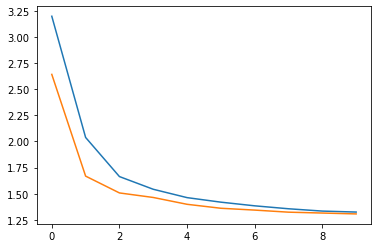

In [16]:
import matplotlib.pyplot as plt
import tqdm


def iterate_batches(data, batch_size, device):
    x, y, max_len = [], [], 0
    for k in tqdm.tqdm(range(len(data))):
        item = data[k]
        x.append([sym2idx[sym] for sym in ["<start>"] + list(item)])
        y.append([sym2idx[sym] for sym in list(item) + ["<end>"]])
        max_len = max(max_len, len(x[-1]))
        if len(x) == batch_size or k + 1 == len(data):
            for i in range(len(x)):
                x[i] = x[i] + [sym2idx["<empty>"] for _ in range(max_len - len(x[i]))]
                y[i] = y[i] + [sym2idx["<empty>"] for _ in range(max_len - len(y[i]))]
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            yield x, y
            x, y, max_len = [], [], 0
        

def train_epoch(data, model):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.AdamW(model.parameters())
    total_loss, total_count = 0.0, 1e-38
    random.shuffle(data)
    for inputs, answers in iterate_batches(data, 256, device):
        optimizer.zero_grad()
        #print(inputs.shape)
        #print(answers.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        outputs = outputs.transpose(1, 2)
        #print(outputs.shape)
        #print("")
        loss = loss_function(outputs, answers)
        total_loss += (loss.item() * inputs.shape[0])
        total_count += inputs.shape[0]
        loss.backward()
        optimizer.step()
    return total_loss / total_count

def test_epoch(data, model):
    with torch.no_grad():
        model.eval()
        loss_function = torch.nn.CrossEntropyLoss()
        total_loss, total_count = 0.0, 1e-38
        for inputs, answers in iterate_batches(data, 256, device):
            outputs = model(inputs)
            outputs = outputs.transpose(1, 2)
            loss = loss_function(outputs, answers)
            total_loss += (loss.item() * inputs.shape[0])
            total_count += inputs.shape[0]
        return total_loss / total_count

train_losses, test_losses = [], []
for i in range(10):
    train_loss = train_epoch(train, model)
    test_loss = test_epoch(test, model)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Epoch {} loss: {:.5f} {:.5f}".format(i, train_loss, test_loss))
    print(generate(model, max_seq_len))
    print("")
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()